In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the libraries:

In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import seaborn as sns
import PIL
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cwd = os.getcwd()
from sklearn.metrics import roc_auc_score
import csv
from glob import glob

In [3]:
os.chdir('/content/drive/MyDrive/Udacity') 
path = os.getcwd()

print(path)
cwd = os.getcwd()

/content/drive/MyDrive/Udacity


In [4]:
PIL.__version__

'7.1.2'

As the classes are processed as numbers, they shall be translated to the corresponding names again:

In [5]:
cat_to_name = {"2": "Seborrheic Keratosis","1": "Nevus", "0": "Melanoma"}

The trained Model shall be loaded and used to classify different types of Skin anomalies.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
print(device)

cpu


In [7]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

state_dict = torch.load('checkpoint.pth',map_location=torch.device('cpu'))
print(state_dict.keys())

def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load('checkpoint.pth',map_location=torch.device('cpu'))
    model = models.vgg16(pretrained=True);
    
    for param in model.parameters(): 
        param.requires_grad = False
    
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

model = load_checkpoint()


dict_keys(['state_dict', 'optimizer', 'class_to_idx', 'classifier'])


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

A support function to process an image, so that the model can read it:

In [8]:
data_dir = 'Skin_Cancer/data'
test_dir = data_dir + '/test'

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    with Image.open(image_path) as image:  
        image =test_transforms(image).numpy()
        
    return image

#print(test_data)
#print(testloader)

Another support function to plot an Input picture:

In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Example of a Test Pic:

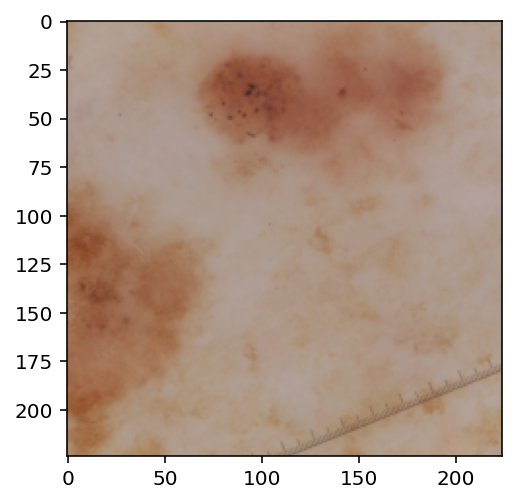

In [10]:
#Test
imshow(process_image("Skin_Cancer/data/test/melanoma/ISIC_0013073.jpg"));

Now the class of an Input Image shall be predicted with the trained model:

In [11]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    py_np_image = process_image(image_path)
    
    # Changing from numpy to pytorch tensor
    py_tensor = torch.tensor(py_np_image).float()
    py_tensor = py_tensor.unsqueeze(0)
    #print(py_tensor.shape)
    # Forward + Eval Mode
    model.eval()
    predictions = model.forward(py_tensor)
    predictions = torch.exp(predictions)
    
    #  top predictions and top labels
    top_predictions, top_labels = predictions.topk(3)
    top_predictions = top_predictions.detach().numpy().tolist()
    top_labels = top_labels.tolist()
    
    # Link of the class to the cancer type in labels
    labels = pd.DataFrame({'class':pd.Series(model.class_to_idx),'cancer_type':pd.Series(cat_to_name)})
    labels = labels.set_index('class')
    
    # Limit to top predictions
    labels = labels.iloc[top_labels[0]]
    labels['predictions'] = top_predictions[0]
    #print(labels)
    #print(top_labels)
    return labels

All 3 solutions shall be plotted with their estimated probabilities to check the robustness of the estimation:

In [12]:
def plot_solution(image_path):
    
    labels = predict(image_path,model)
    
    plt.figure(figsize=(5,10))
    ax = plt.subplot(2,1,1)
    img = process_image(image_path)
    imshow(img,ax,#title=title_
          );

    sns.set_style("whitegrid")
    plt.subplot(2,1,2)
    sns.barplot(x=labels['predictions'],y=labels['cancer_type'],color='#047495')
    plt.xlabel("Probability of Prediction")
    plt.ylabel("")
    plt.show();

sns.set_style("white")

The Melanoma on this image is predicted with a probability of 0,65 and is therefor classified as Melanoma.

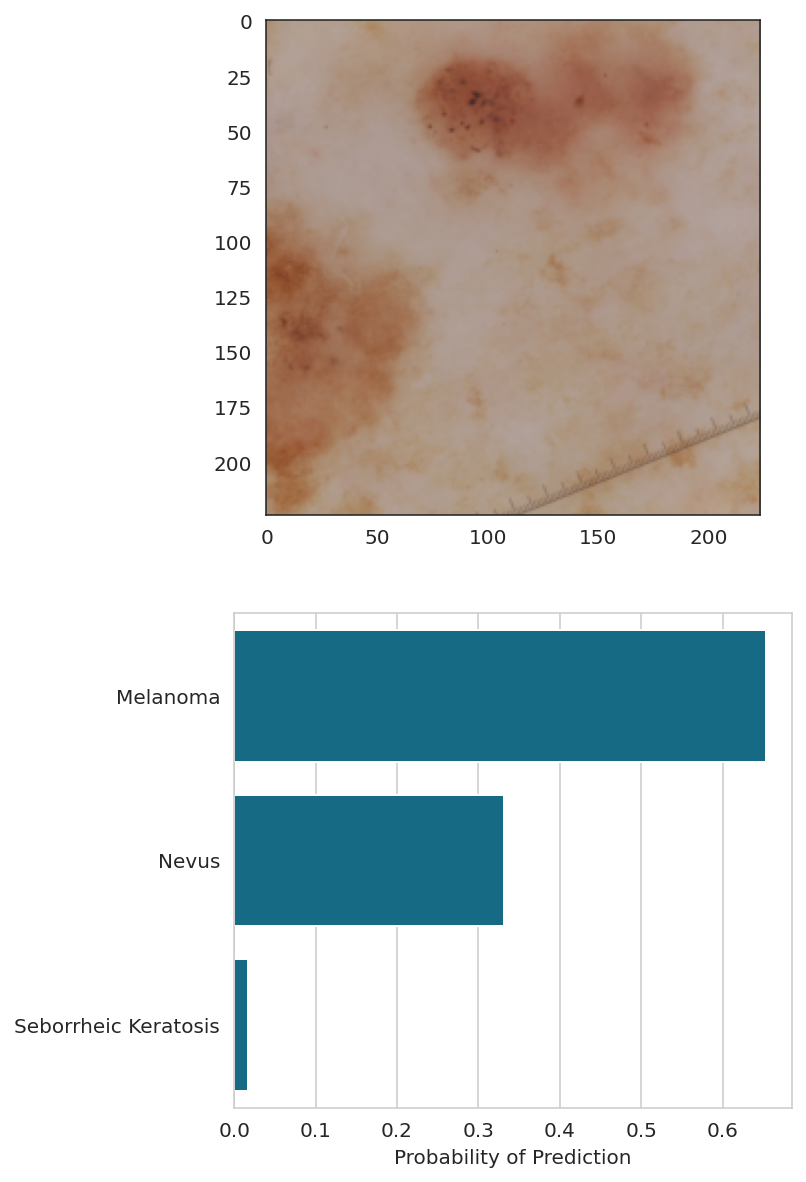

In [13]:
plot_solution("Skin_Cancer/data/test/melanoma/ISIC_0013073.jpg")

Export Results to a CSV file to enable evaluation:

In [14]:

# TODO: Do validation on the test set
def get_predictions(model, testloader):
  score_1 = []
  score_2 = []
  with torch.no_grad():
      model.eval()
      for images, labels in testloader:
                  
                  images = images.to(device)
                  labels = labels.to(device)
                  log_ps = model(images)
                  predictions = torch.exp(log_ps)
                  s1 = predictions[0,0].numpy()
                  s2 = predictions[0,2].numpy()
                  score_1.append(float(s1))
                  score_2.append(float(s2))
                  #print(len(score_2))


  return score_1, score_2 

 

In [15]:
# load filenames for images
train_files_path = []
valid_files_path = []
test_files_path = []
files = ['train_files_path', 'valid_files_path', 'test_files_path']
mypath = os.getcwd() + '/Skin_Cancer/'
#print(mypath)
for file in files:
    folder = file.split('_')[0]
    path = os.path.join(mypath, 'data', folder)
    for dir_ in os.listdir(path):
        subpath=os.path.join(path, dir_)
        if folder == 'train':
            train_files_path.extend(glob(subpath+'/*'))
        elif folder == 'valid':
            valid_files_path.extend(glob(subpath+'/*'))
        else:
            test_files_path.extend(glob(subpath+'/*'))
ID_list=[]
for i in range(len(test_files_path)):
  ID_list.append(os.path.join(*(test_files_path[i].split(os.path.sep)[6:])))

print('Example of Path stored in ID List:', ID_list[4])

print('There are %d total test images and their path asaved in the variable test_files_path.' % len(test_files_path))


data/test/melanoma/ISIC_0013073.jpg
There are 600 total test images and their path asaved in the variable test_files_path.


The following function provides the CSV file, which shall be used to evaluate the accuracy of the Classifier:

In [16]:
def get_scores(model, testloader):
    
    print("\ngetting predictions on all test images:")
    score_1, score_2 = get_predictions(model, testloader)
    
    print("writing score csv file")
    with open('results.csv', 'w', newline='') as csvfile:
        doc = csv.writer(csvfile)
        doc.writerow(['Id', 'task_1', 'task_2'])
        for i in range(len(ID_list)):
            doc.writerow([ID_list[i], score_1[i], score_2[i]])
        
    #plot_scores()

In [17]:
get_scores(model, testloader)


getting predictions on all test images:
writing score csv file


Result 1:

Epochs: 5

Model: VGG16 (+ 2 layer Classifier with 0,15 Dropout)

Criterion: NLLLoss

Optimizer: Adam

Category 1 Score: 0.730

Category 2 Score: 0.825

Category 3 Score: 0.778

ROC Matrix

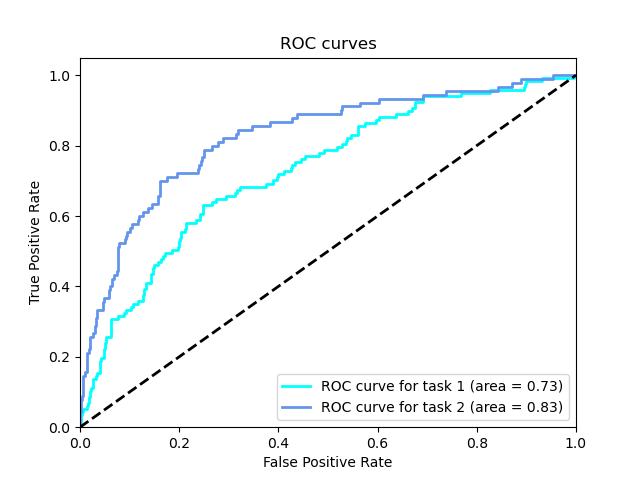

Confusion Matrix

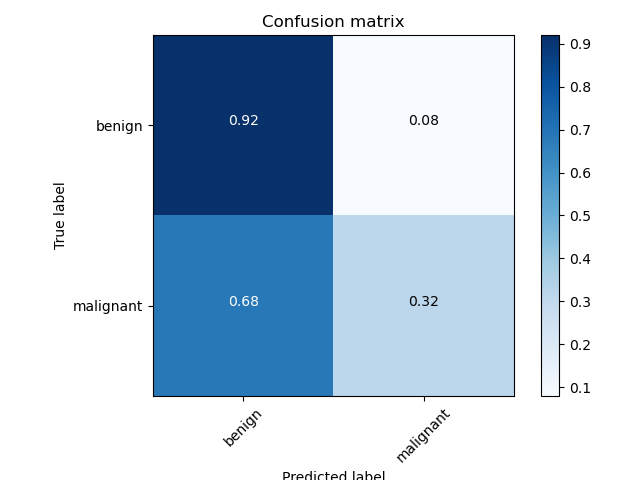

An average result of 0,778 is better than expected with only 5 Epochs. Nevertheless, the weak part of this result is the high false negative result of 0,68 (as documented in the confusion matrix). This results in the fact that people with a malignant melanom are classified as healthy, with the consequence, that they wouldn't go to the doctor and in the worst case die.

A better classifier should minimize the false negative results, even if the false positive results increase. A healthy patient, which is diagnosed with melanoma, goes to the doctor and will be then diagnosed as healthy. This results only in wasted time and is preferred than the false negative result.

One way to reduce the false negative probability is a better classifier, with another network, a higher epoch rate or another criterion/optimizer. Another way is an increase of the estimated result percentage, when a benign melanom is classified (e.g. an increase from min 0,5 to min 0,6 or min 0,7).

Last but not least, additional data could be taken into account like age or sex.

The influence of different variables to improve the classifier shall be further investigated within this project.